### Single-particle tracking pipeline for 2D data
Input: 
> Set of localizations, currently accepting ThunderStorm format \
> You need to change some of the parameters here and there; the text before the code cells will tell you \

Output:  
 >   1. Linked trajectories
  >  2. MSD analysis/graphs with trackpy
   > 3. MSD fits (D*, alpha) with graphs
>

Dependencies:
> matplotlib, pandas, numpy \
> trackpy, scipy, seaborn

#### Load all packages

In [2]:
%matplotlib inline
import matplotlib as mpl

import matplotlib.pyplot as plt, pandas as pd, numpy as np     # all necessary

import trackpy as tp

from scipy.optimize import curve_fit
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['text.usetex'] = False
mpl.rcParams['axes.titlesize'] = 20  # Title font size
mpl.rcParams['axes.labelsize'] = 16  # Axis label font size
mpl.rcParams['xtick.labelsize'] = 14  # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 14  # Y-axis tick label font size
plt.rc('legend',fontsize=14,title_fontsize=14)

#plt.rc('legend',fontsize='large')
plt.style.use('seaborn-v0_8-white')
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.size'] = 5
plt.rcParams["font.family"] = 'Arial'

#### Initialize all the functions

In [3]:
def load_locs(dir,fn, conv_factor):
    locs = pd.read_csv(dir+fn)
    locs = locs[["frame","x [nm]","y [nm]"]].rename(columns={"x [nm]": "x", "y [nm]": "y"}, errors = 'raise')

    conv_factor = conv_factor
    locs = locs.mul({'frame':1,'x':conv_factor,'y':conv_factor})  # convert to um
    locs['file'] = fn
    return locs
    
def track_and_filter(locs, search_range, memory, min_track,fn):
    trajs = tp.link(locs, search_range, memory = memory, link_strategy = 'auto')      # trackpy links with the Crocker & Grier algorithm

    tracks = tp.filter_stubs(trajs, min_track)  

    if len(tracks) > 0:
        fig, ax = plt.subplots(figsize=(7,7))
        tp.plot_traj(tracks, mpp = 1, ax = ax)
        plt.axis('equal')
        
        plt.savefig(fn+'_tracks.svg')
    return tracks

    
def calc_imsds(tracks, mpp, fps, maxlag, fn):
    im = tp.imsd(tracks, mpp, fps, max_lagtime = maxlag)
    imsr = im.round(7)
    im = imsr.T.drop_duplicates().T
    fig, ax = plt.subplots(figsize=(7,7))
    ax.plot(im.index, im, 'k-', alpha=0.3)  # black lines, semitransparent
    ax.set(ylabel=r'MSD [$\mu$m$^2$]',
           xlabel='lag time $t (s)$')
    ax.set_yscale('linear')
    ax.set_xscale('linear')
    ax.set_ylabel('MSD (um^2)')
    ax.set_title('iMSDs')
    #ax.set_ylim([0, 0.0075])
    #ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    #ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    plt.savefig(fn)
    return im

def msd_2D_log(lag, D_eff,  alpha, sigma):
    #t_exp = 0.05
    return np.log((4*D_eff*np.power(lag,alpha)) + 4*np.power(sigma,2))

def msd_2D(lag, D_eff,  alpha, sigma):
    #t_exp = 0.05
    return ((4*D_eff*np.power(lag,alpha)) + 4*np.power(sigma,2))

def backlund_msd_2D(lag,D_eff,alpha,sigma):
    t_exp = 0.05
    lag = lag/t_exp
    return ((((4*D_eff*np.power(t_exp,alpha))*(np.power(lag+1,alpha+2) + 
                                            np.power(lag-1,alpha+2) -
                                            2*np.power(lag,alpha+2)))/((alpha+2)*(alpha+1))) -
                                            (8*D_eff*np.power(t_exp,alpha)/((alpha+2)*(alpha+1))) +
                                            4*np.power(sigma,2))

def backlund_msd_2D_log(lag,D_eff,alpha,sigma):
    t_exp = 0.05
    lag = lag/t_exp
    return np.log(((((4*D_eff*np.power(t_exp,alpha))*(np.power(lag+1,alpha+2) + 
                                            np.power(lag-1,alpha+2) -
                                            2*np.power(lag,alpha+2)))/((alpha+2)*(alpha+1))) -
                                            (8*D_eff*np.power(t_exp,alpha)/((alpha+2)*(alpha+1))) +
                                            4*np.power(sigma,2)))

from matplotlib.lines import Line2D
import warnings
def fit_imsds(im, t_exp, fn,fitback):
    fits = pd.DataFrame()
    fits.index = im.index
    xdata = im.index.to_numpy() 
    bounds=([0.000001, 0.01, 0.001], [0.1, 2., 0.1])
    p0 = [0.001,0.5,0.02]
    
    params = pd.DataFrame()
    params.index = ['D_eff', 'alpha', 'sigma']
    
    for i in im.columns:   
        if fitback:
            popt, pcov = curve_fit(backlund_msd_2D_log, xdata, np.log(im[i].to_numpy()), bounds=bounds, p0 = p0, maxfev=5000)
            fits['Fit of ' + str(i)] = backlund_msd_2D(xdata,*popt)
        else:
            popt, pcov = curve_fit(msd_2D_log, xdata, np.log(im[i].to_numpy()), bounds=bounds, p0 = p0, maxfev=5000)
            fits['Fit of ' + str(i)] = msd_2D(xdata,*popt)
        params[i] = popt

    fig, ax = plt.subplots(figsize=(7,7))
    im.plot(style = 'k-',alpha = 0.2, linewidth = 2, ax = ax)
    warnings.filterwarnings('ignore')
    fits.plot(ax=ax,style = 'k--',alpha = 0.6, linewidth = 2)
    warnings.filterwarnings('ignore')
    plt.yscale('linear')
    plt.xscale('linear')
    plt.ylabel('MSD (um^2)')
    plt.title('Fit to 2D MSD')
    #plt.ylim([0, 0.0075])
    #ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    #ax.set_xticks([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    lined = Line2D([0], [0], label='Data', color='k', linestyle = '-')
    linef = Line2D([0], [0], label='Fit', color='k', linestyle = '--')
    plt.legend(handles=[lined, linef])
    plt.savefig(fn)
    return params

def plot_scatter(params,fn):
    params.transpose().plot.scatter('D_eff','alpha', c = 'k',alpha = 0.3)
    plt.xscale('log')
    plt.xlabel(r'Diffusion Coefficient $\left(\frac{\mu m^{2}}{s^{\alpha}}\right)$')
    plt.ylabel(r'Anomolous Exponent $\left(au\right)$')
    plt.tight_layout()
    plt.savefig(fn)

def plot_violin(params,fn):
    from matplotlib import ticker as mticker

    params = params.transpose()
    data = params['D_eff'].values
    log_data = [np.log10(d) for d in data]
    
    fig, ax = plt.subplots(ncols=3, figsize=(14, 7), sharey=False)
    sns.stripplot(data=log_data, ax=ax[0], jitter = True, color = 'black',alpha = 0.25)
    sns.violinplot(data=log_data, ax=ax[0])
    ax[0].set_ylim([-4.5,-1.5])
    ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    ymin, ymax = ax[0].get_ylim()
    tick_range = np.arange(np.floor(ymin), ymax)
    ax[0].yaxis.set_ticks(tick_range)
    ax[0].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    ax[0].title.set_text(r'Diffusion Coefficient $\left(\frac{\mu m^{2}}{s^{\alpha}}\right)$')
    ax[0].set_xlabel('')
    ax[0].set_xticklabels('')
    
    data = params['alpha'].values
    
    
    sns.stripplot(data=data, ax=ax[1], jitter = True, color = 'black',alpha = 0.25)
    sns.violinplot(data=data, ax=ax[1], color = 'orange')
    ax[1].title.set_text(r'Anomolous Exponent $\left(au\right)$')
    #ax[1].set_ylabel('au')
    ax[1].set_xlabel('')
    ax[1].set_xticklabels('')

    data = params['sigma'].values
    
    
    sns.stripplot(data=data, ax=ax[2], jitter = True, color = 'black',alpha = 0.25)
    sns.violinplot(data=data, ax=ax[2], color = 'green')
    ax[2].title.set_text(r'Localization Error $\left(\mu m\right)$')
    ax[2].set_xlabel('')
    ax[2].set_xticklabels('')
    
    plt.tight_layout()
    plt.savefig(fn)
    plt.show()

def plot_box(params,fn):
    from matplotlib import ticker as mticker

    params = params.transpose()
    data = params['D_eff'].values
    log_data = [np.log10(d) for d in data]
    
    fig, ax = plt.subplots(ncols=2, figsize=(7, 7), sharey=False)
    sns.swarmplot(data=log_data, ax=ax[0], color = 'black',alpha = 0.25)
    sns.boxplot(data=log_data, ax=ax[0],showfliers=False)
    
    ax[0].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    ymin, ymax = ax[0].get_ylim()
    tick_range = np.arange(np.floor(ymin), ymax)
    ax[0].yaxis.set_ticks(tick_range)
    ax[0].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    ax[0].title.set_text(r'Diffusion Coefficient $\left(\frac{\mu m^{2}}{s^{\alpha}}\right)$')
    #ax[0].set_ylabel(r'$\left(\frac{\mu m^{2}}{s^{\alpha}}\right)$')
    ax[0].set_xlabel('')
    ax[0].set_xticklabels('')
    
    data = params['alpha'].values
    
    
    sns.swarmplot(data=data, ax=ax[1], color = 'black',alpha = 0.25)
    sns.boxplot(data=data, ax=ax[1], color = 'orange',showfliers=False)
    ax[1].title.set_text(r'Anomolous Exponent $\left(au\right)$')
    ax[1].set_xlabel('')
    ax[1].set_xticklabels('')
    
    plt.tight_layout()
    plt.savefig(fn)
    plt.show()

### Load files
> change basedir to folder for this project \
> change dirn to folder with the localization files to be analyzed \
> change outname to folder to be used to save the outputs

In [7]:
basedir = ""  # change to directory for project
dirn = basedir + "telomeres\\" # folder with localizations
filenames = os.listdir(dirn)
outname = basedir+'output\\'  # create this folder in your directory for outputs
print(filenames)

['cell1.csv', 'cell2.csv', 'cell3a.csv', 'cell3b.csv', 'cell4.csv']


### Load localizations and track things
> Change "conv_factor" to your pixel size in um, assuming input data is in pixels (if in nm, set to 0.001) \
>"fitback" : fit using Backlund equation (1) or not (0)
> "max_dist" : maximum allowed step size of a particle (in um) \
> "max_off" : maximum allowed off frames to stille be counted as the same particle (in frames) \
> "min_track" : minimum track length (in frames)

Frame 400: 39 trajectories present.


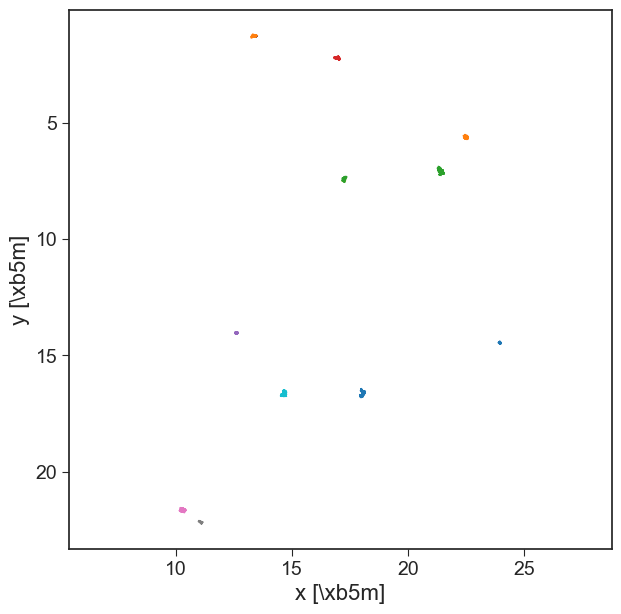

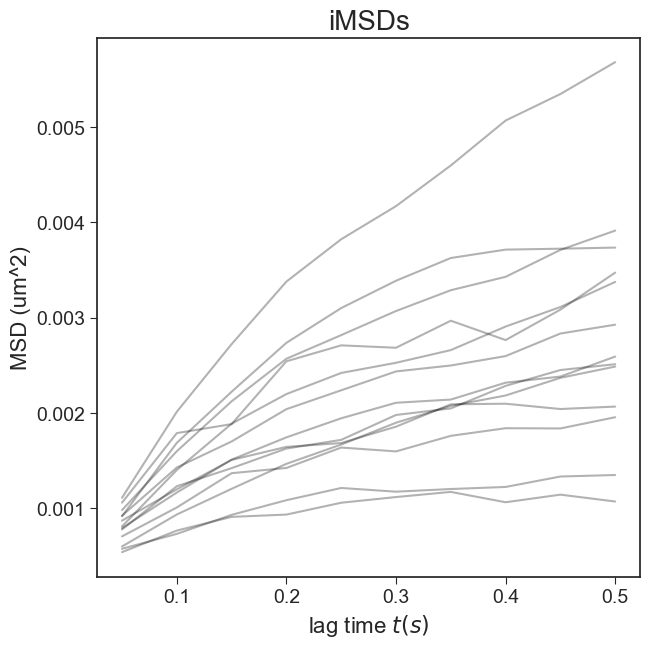

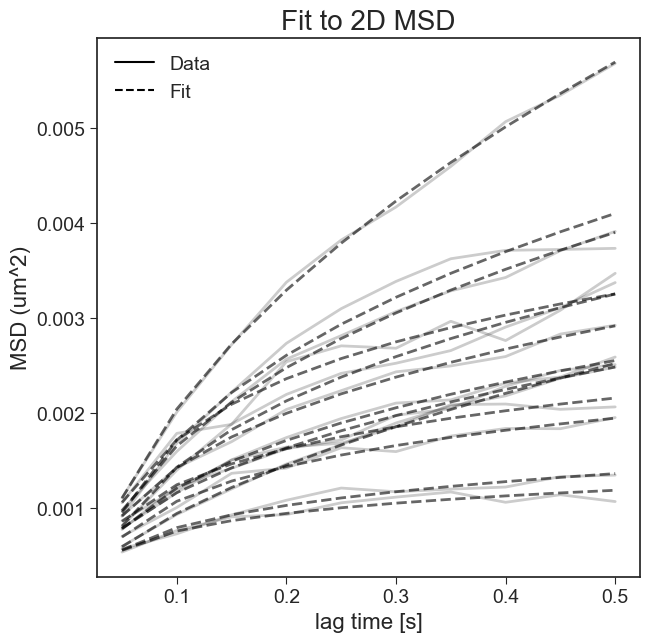

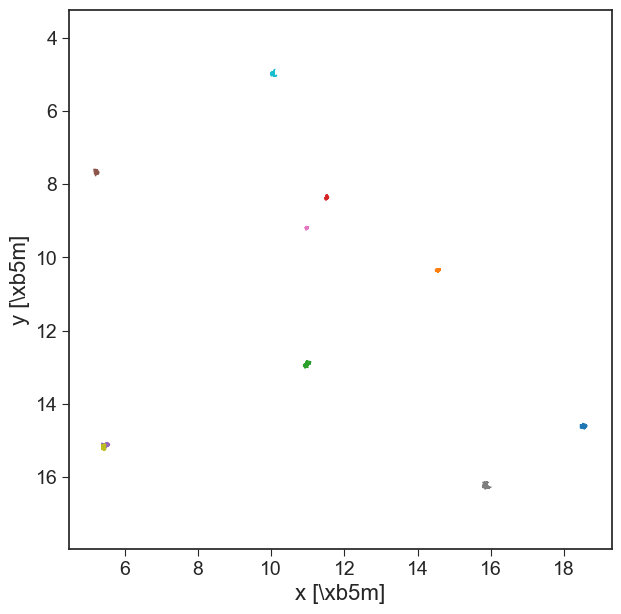

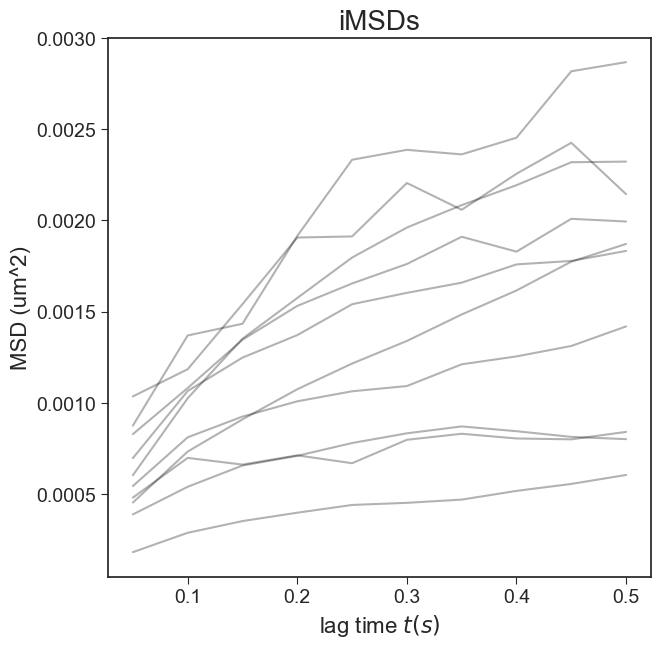

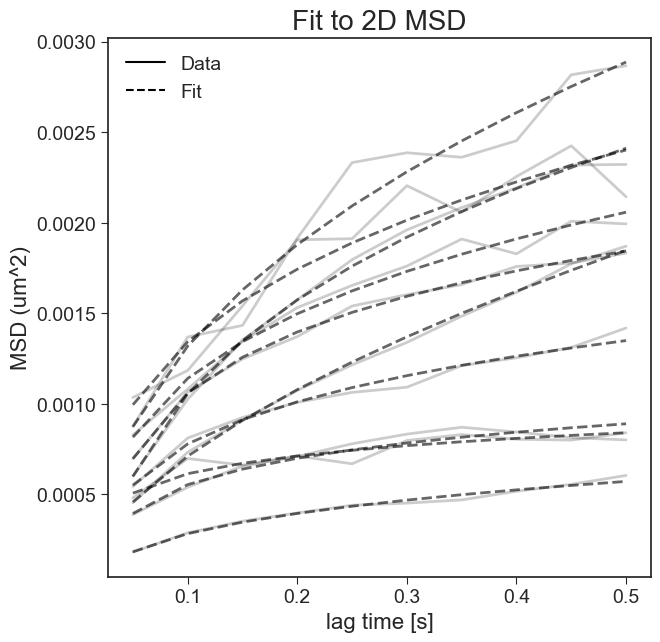

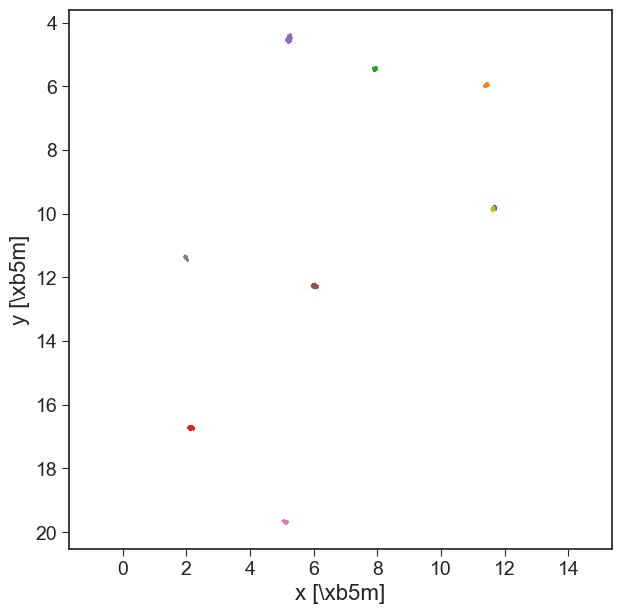

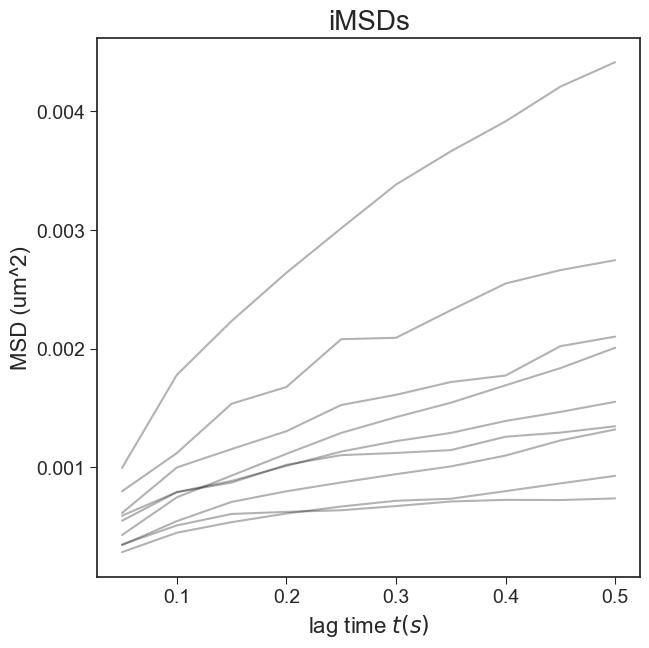

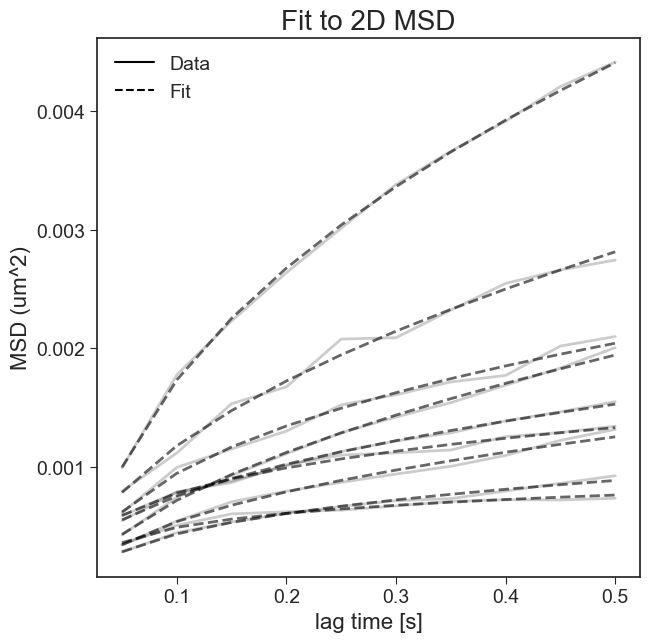

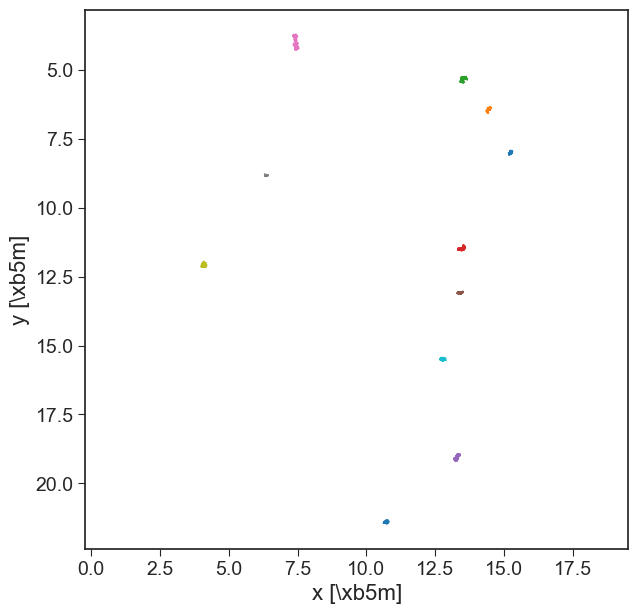

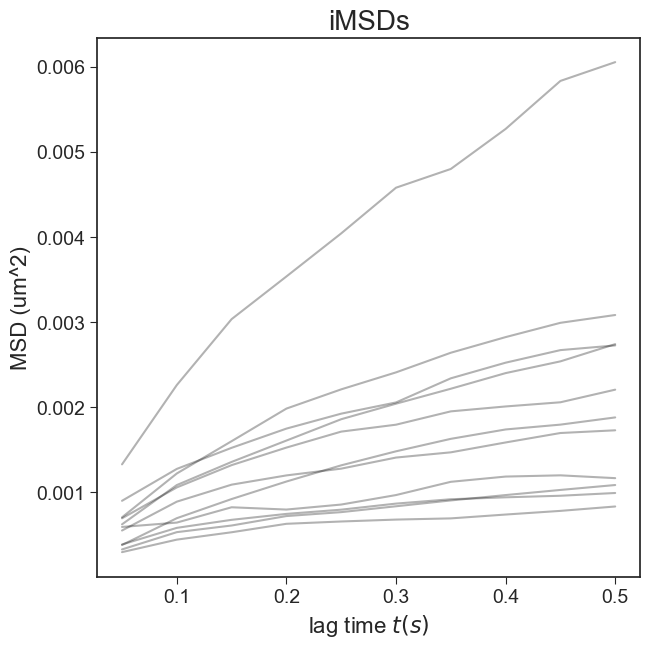

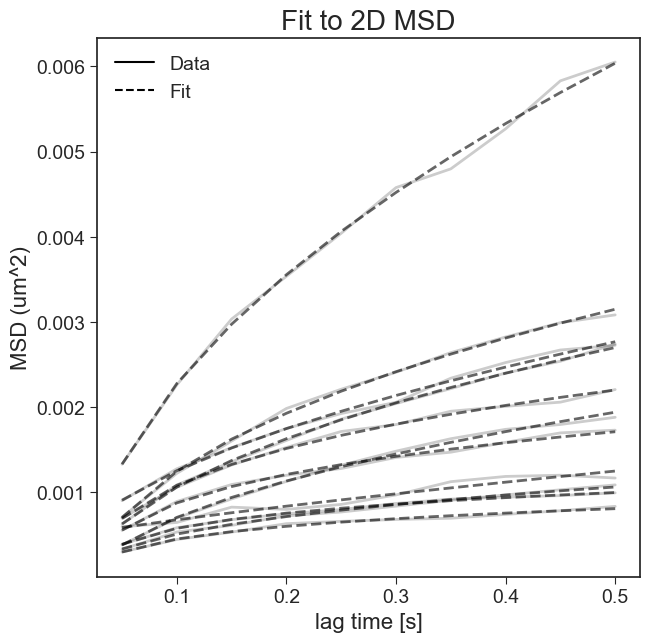

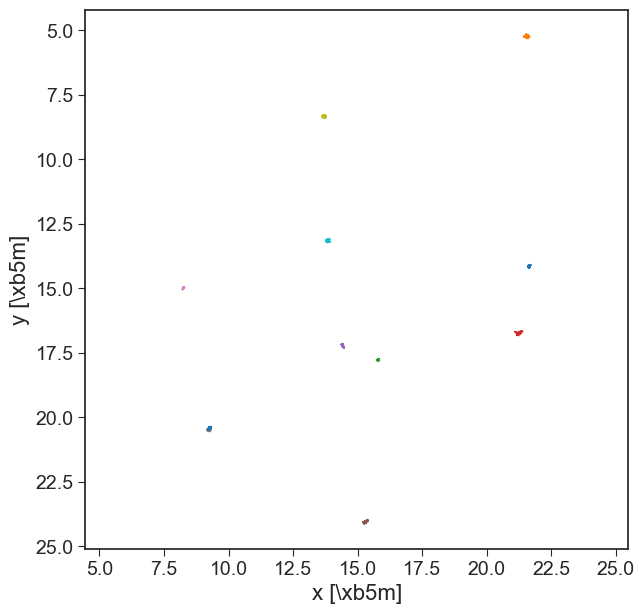

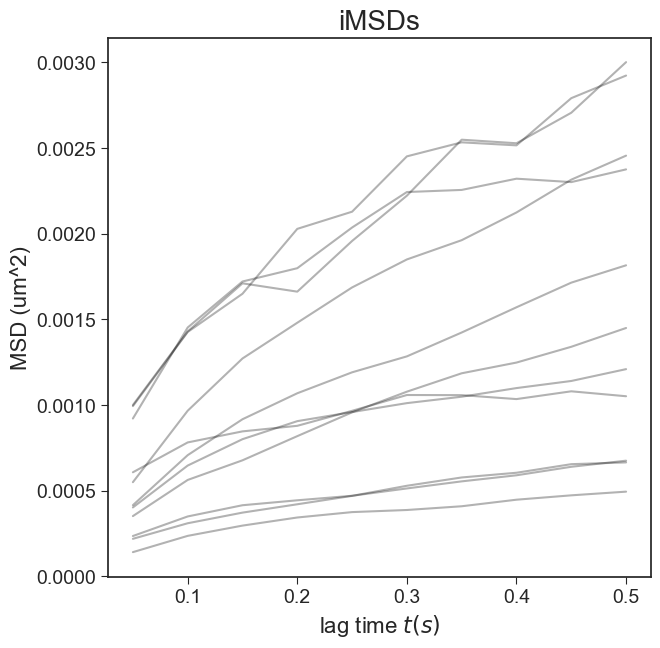

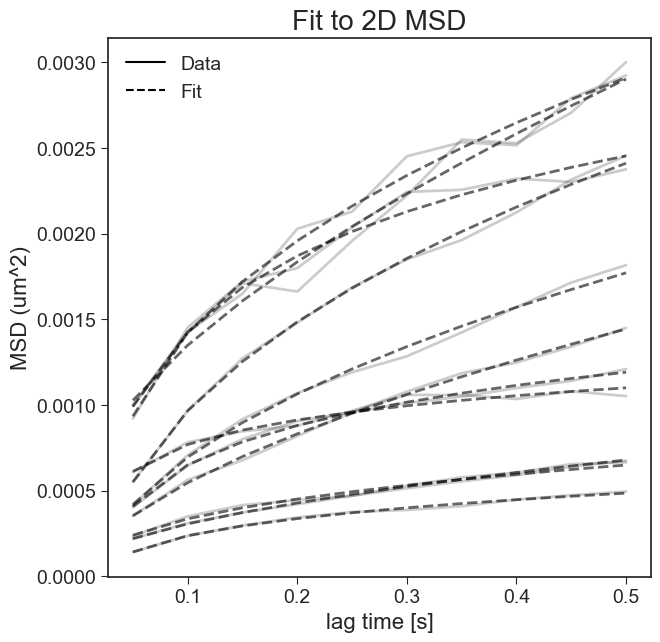

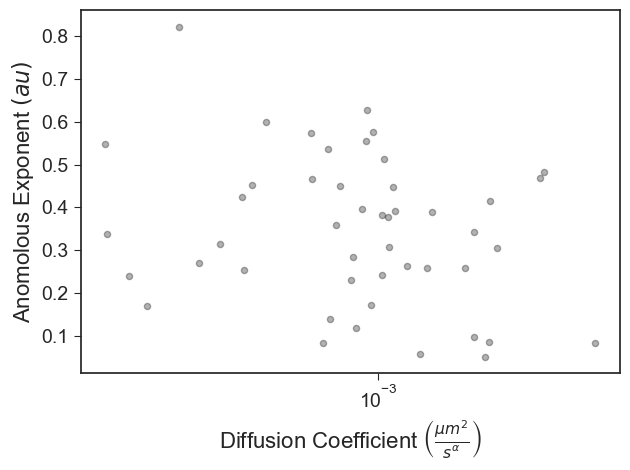

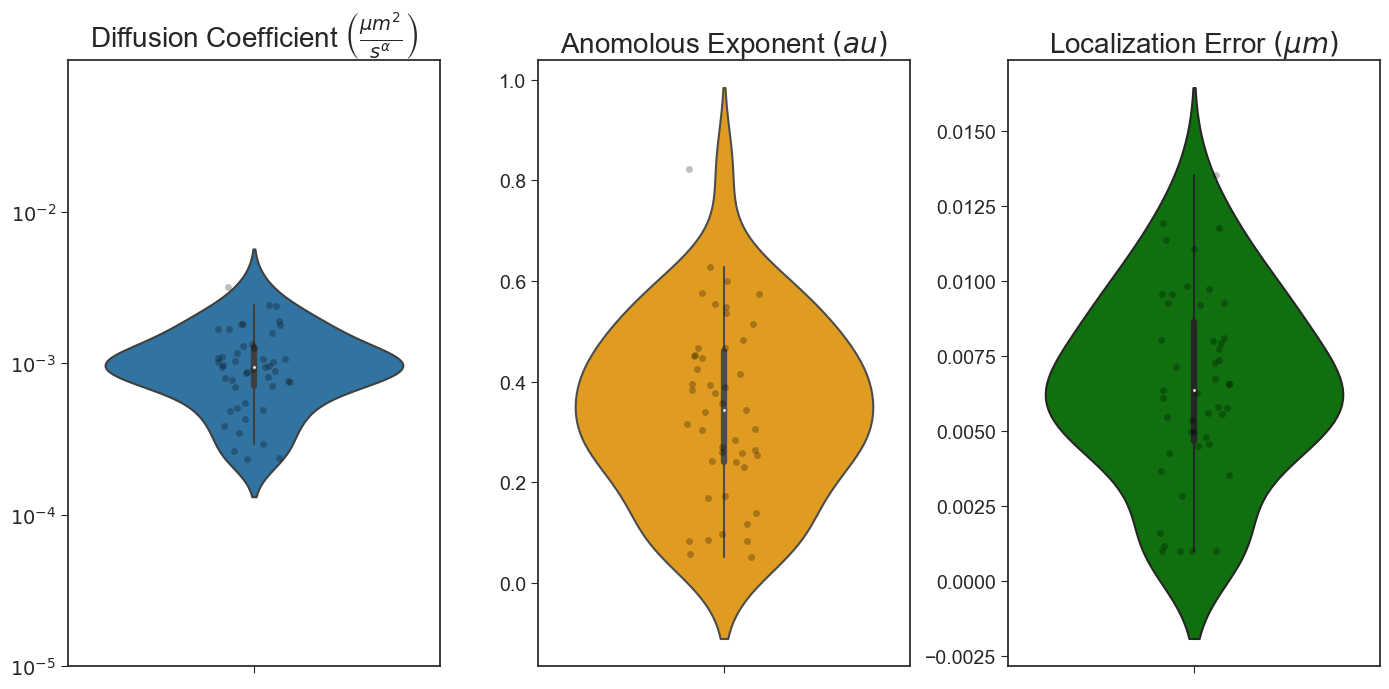

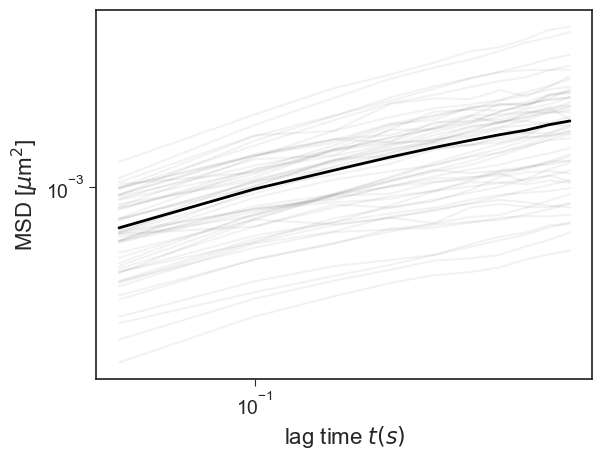

In [8]:
condition = 'TEST'   # change to condition of this group of cells (e.g. 'Control')
conv_factor = 0.001   # test data is in nm
fitback = 1           # 1 = use Backlund fit, 0 = standard 2D MSD (with localization error)
max_dist = 0.25 # max distance between consecutive localizations in a track (250 nm here)
max_off = 3     # max number of gaps in a track
min_track = 100   # set minimum frames for a track

all_params = pd.DataFrame()
all_imsds = pd.DataFrame()

for i,fn in enumerate(filenames):
    savename = os.path.splitext(fn)[0]
    locs = load_locs(dirn,fn,conv_factor) 
    
    all_tracks = track_and_filter(locs, max_dist, max_off, min_track,outname+savename)   # perform linking
    if len(all_tracks) < 1:                   # if no tracks left, skip to next
        continue
        
    all_tracks.to_csv(outname+savename+".csv")        # save tracks to file
    fps = 20        # video rate
    max_lag = 10    # lag to calculate MSD out to

    # Next: calculate iMSDs, perform fits, plot plots
    ims = calc_imsds(all_tracks, 1, fps, max_lag, outname+savename+'_iMSDs.svg')
    params = fit_imsds(ims,1/fps,outname+savename+'_fitMSDs.svg',fitback=fitback) # fitback is variable to fit using backlund equation (1 = YES)
    
    all_params = pd.concat([all_params, params.transpose()], ignore_index=True)
    all_imsds = pd.concat([all_imsds, ims.transpose()], ignore_index=True)
    
# Plot plots of all recovered parameters together
all_params = all_params[all_params.alpha<1.95] # filter out bad fits
all_params = all_params[all_params.alpha>0.05] # filter out bad fits

# Plot plots:
savename = condition
plot_scatter(all_params.transpose(),outname+savename+'_scatter.svg')
plot_violin(all_params.transpose(),outname+savename+'_violin.svg')
all_params.to_csv(outname+savename+'_params.csv')
all_imsds.to_csv(outname+savename+'_iMSDs.csv')

fig, ax = plt.subplots()
ax.plot(all_imsds.transpose().index, all_imsds.transpose(), 'k-', alpha=0.05)  # black lines, semitransparent
ax.plot(all_imsds.transpose().index,all_imsds.mean().values, 'k-', alpha = 1, linewidth = 2)
ax.set(ylabel=r'MSD [$\mu$m$^2$]',
       xlabel='lag time $t (s)$')
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.set_xscale('log')
ax.set_yscale('log')
plt.savefig(outname + savename+'_msd.svg')